# Comparison between L2 and L1 (Lasso) regularization

## Import libreries and define global variables

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from NeuralNetwork import NeuralNetwork
from utils import get_data, onehot_encoding, grid_search, save_dict_to_file, load_dict_from_file, cross_validation
from Layer import Layer, Input
from functions import accuracy, MSE, MEE
import pandas as pd
import seaborn as sn
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

In [2]:
DIR = '/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/' # Directory of the package.

## Import datasets

### Import MONK datasets

In [3]:
df = get_data(f'{DIR}data/MONK/monks-3.train')
df_test = get_data(f'{DIR}data/MONK/monks-3.test')

X_train_monk, y_train_monk = df.drop(columns=['target','id']).to_numpy().T, df['target'].apply(lambda x: int(x)).to_numpy().T
X_test_monk, y_test_monk = df_test.drop(columns=['target','id']).to_numpy().T, df_test['target'].apply(lambda x: int(x)).to_numpy().T

### Import CUP dataset

Define the fraction of dataset which will represent the internal test set.

In [4]:
test_frac = 1/4

In [5]:
names = ['id', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 
         'feature_7', 'feature_8', 'feature_9', 'feature_10', 'target_x', 'target_y','target_z']

df = pd.read_csv(f"{DIR}data/ML-CUP23-TR.csv", names=names, comment='#')

targets = ['target_x', 'target_y', 'target_z']
features = list(set(names) - {'id', 'target_x', 'target_y', 'target_z'})

df = df.sample(frac=1)

train_test_div = round((1-test_frac) * df.shape[0])

X_train_cup, y_train_cup = df[:train_test_div][features].to_numpy().T, df[:train_test_div][targets].to_numpy().T
X_test_cup, y_test_cup = df[train_test_div:][features].to_numpy().T, df[train_test_div:][targets].to_numpy().T

## Data preprocessing

### MONK preprocessing

Process one hot encoding on training and test sets.

In [6]:
X_train_monk = onehot_encoding(X_train_monk)
X_test_monk = onehot_encoding(X_test_monk)

### CUP preprocessing

Decide which data preprocessing method apply to cup training set:
+ MinMax normalization (preprocessing = 1)
+ Standardization (preprocessing = 2)

In [7]:
preprocessing = 0

In [8]:
if preprocessing == 1:
    X_train_cup = minmax_norm(X_train_cup)
    X_test_cup = minmax_norm(X_test_cup)
elif preprocessing == 2:
    X_train_cup = standard(X_train_cup)
    X_test_cup = standard(X_test_cup)

## MONK

Define training and model hyperparameters

In [42]:
orig_params = {'hidden_dim': 4,
        'hidden_act_func': 'tanh',
        'eta': 0.05,
        'lam': 4e-04,
        'alpha': 0.5,
        'n_batch': X_train_monk.shape[1],
        'use_opt':0,
        'nest': False,
        'l1_reg' : False,
        'epochs' : 500
        }
seed = np.random.randint(10,1000)

### L2 regularization

Build model

In [43]:
params = orig_params.copy()
input_layer = Input(17)
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'), init_weights_mode='rand')
output_layer = Layer(hidden_layer, 1, 'sigm', init_weights_mode='rand')

model = NeuralNetwork(input_layer, output_layer, loss = 'binary_crossentropy', metrics = [accuracy, MSE])

init_weights_list = model.get_weights_list()

Training with L2 regularization:

In [44]:
np.random.seed(seed)
params['l1_reg'] = False
history_l2 = model.retrain(X_train_monk, y_train_monk.reshape((1,X_train_monk.shape[1])),
                                    test_data = [X_test_monk,y_test_monk.reshape((1,X_test_monk.shape[1]))],
                                    early_stopping=None,
                                    reduce_eta=None,
                                    **params
                                    )

Epoch 0: train_loss: 6.815e-01, test_loss: 6.736e-01; train_accuracy: 5.410e+01, test_accuracy: 5.787e+01  train_MSE: 2.443e-01, test_MSE: 2.404e-01  lr : 0.05
Epoch 1: train_loss: 6.795e-01, test_loss: 6.714e-01; train_accuracy: 5.574e+01, test_accuracy: 5.810e+01  train_MSE: 2.433e-01, test_MSE: 2.393e-01  lr : 0.05
Epoch 2: train_loss: 6.771e-01, test_loss: 6.688e-01; train_accuracy: 5.574e+01, test_accuracy: 5.856e+01  train_MSE: 2.422e-01, test_MSE: 2.380e-01  lr : 0.05
Epoch 3: train_loss: 6.746e-01, test_loss: 6.660e-01; train_accuracy: 5.656e+01, test_accuracy: 6.019e+01  train_MSE: 2.409e-01, test_MSE: 2.366e-01  lr : 0.05
Epoch 4: train_loss: 6.721e-01, test_loss: 6.631e-01; train_accuracy: 5.656e+01, test_accuracy: 6.042e+01  train_MSE: 2.397e-01, test_MSE: 2.353e-01  lr : 0.05
Epoch 5: train_loss: 6.695e-01, test_loss: 6.603e-01; train_accuracy: 5.820e+01, test_accuracy: 6.157e+01  train_MSE: 2.384e-01, test_MSE: 2.339e-01  lr : 0.05
Epoch 6: train_loss: 6.669e-01, test_los

In [45]:
l2_weights = model.get_weights_list()

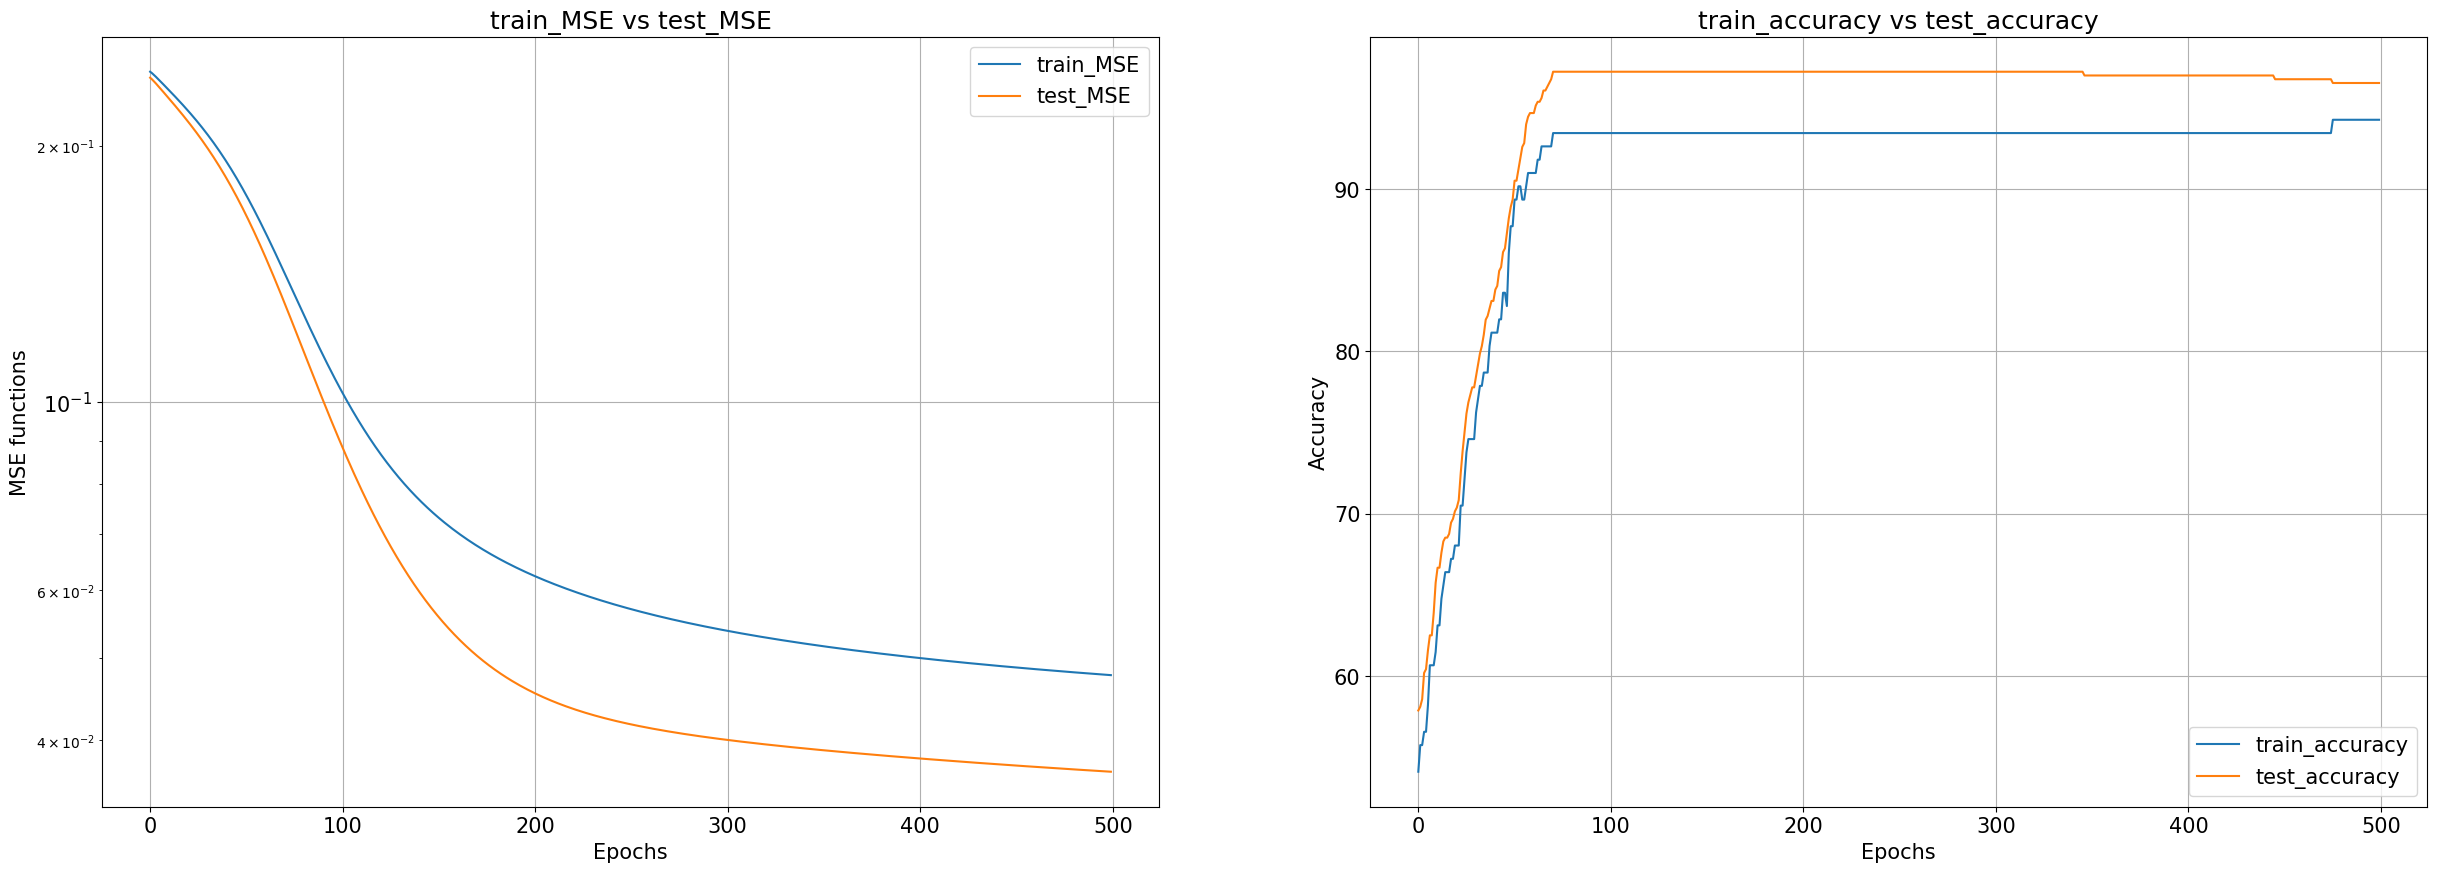

In [46]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_l2['train_MSE'],label='train_MSE')
plt.plot(history_l2['test_MSE'], label='test_MSE')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('MSE functions', size=15)
plt.title('train_MSE vs test_MSE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_l2['train_accuracy'],label='train_accuracy')
plt.plot(history_l2['test_accuracy'], label='test_accuracy')
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.title('train_accuracy vs test_accuracy', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

### L1 regularization


Build model


In [47]:
params = orig_params.copy()
input_layer = Input(17)
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
output_layer = Layer(hidden_layer, 1, 'sigm')

model = NeuralNetwork(input_layer, output_layer, loss = 'binary_crossentropy', metrics = [accuracy, MSE])

model.set_initial_weights(init_weights_list)
arr = model.get_weights_list()

Training with L1 regularization:


In [48]:
np.random.seed(seed)
params['l1_reg'] = True
history_l1 = model.retrain(X_train_monk, y_train_monk.reshape((1,X_train_monk.shape[1])),
                                    test_data = [X_test_monk,y_test_monk.reshape((1,X_test_monk.shape[1]))],
                                    early_stopping=None,
                                    reduce_eta=None,
                                    **params
                                    )

Epoch 0: train_loss: 6.815e-01, test_loss: 6.736e-01; train_accuracy: 5.410e+01, test_accuracy: 5.787e+01  train_MSE: 2.443e-01, test_MSE: 2.404e-01  lr : 0.05
Epoch 1: train_loss: 6.794e-01, test_loss: 6.714e-01; train_accuracy: 5.574e+01, test_accuracy: 5.810e+01  train_MSE: 2.433e-01, test_MSE: 2.393e-01  lr : 0.05
Epoch 2: train_loss: 6.770e-01, test_loss: 6.688e-01; train_accuracy: 5.574e+01, test_accuracy: 5.856e+01  train_MSE: 2.421e-01, test_MSE: 2.380e-01  lr : 0.05
Epoch 3: train_loss: 6.745e-01, test_loss: 6.660e-01; train_accuracy: 5.656e+01, test_accuracy: 5.995e+01  train_MSE: 2.409e-01, test_MSE: 2.367e-01  lr : 0.05
Epoch 4: train_loss: 6.719e-01, test_loss: 6.632e-01; train_accuracy: 5.656e+01, test_accuracy: 6.042e+01  train_MSE: 2.396e-01, test_MSE: 2.353e-01  lr : 0.05
Epoch 5: train_loss: 6.693e-01, test_loss: 6.604e-01; train_accuracy: 5.984e+01, test_accuracy: 6.204e+01  train_MSE: 2.384e-01, test_MSE: 2.339e-01  lr : 0.05
Epoch 6: train_loss: 6.668e-01, test_los

In [49]:
l1_weights = model.get_weights_list()

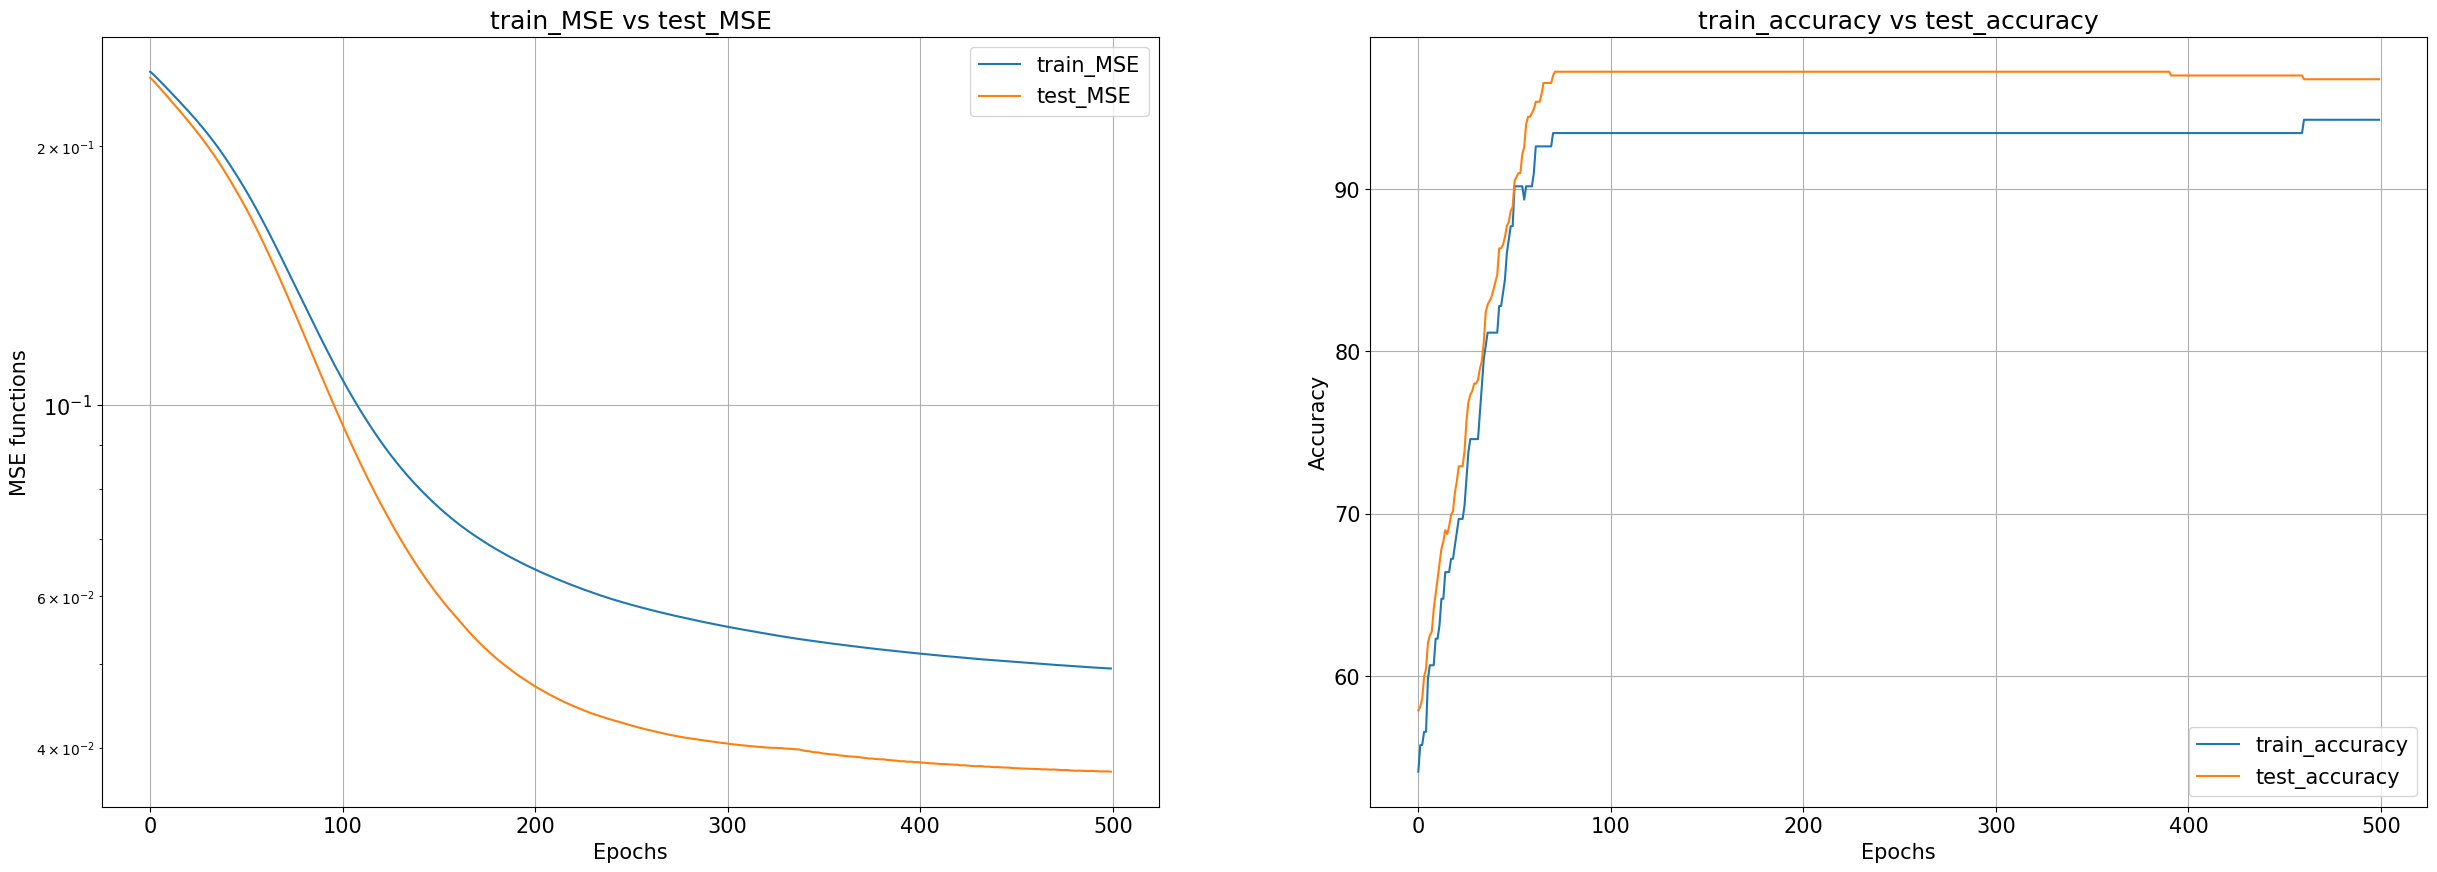

In [50]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_l1['train_MSE'],label='train_MSE')
plt.plot(history_l1['test_MSE'], label='test_MSE')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('MSE functions', size=15)
plt.title('train_MSE vs test_MSE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_l1['train_accuracy'],label='train_accuracy')
plt.plot(history_l1['test_accuracy'], label='test_accuracy')
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.title('train_accuracy vs test_accuracy', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)


### Comparison

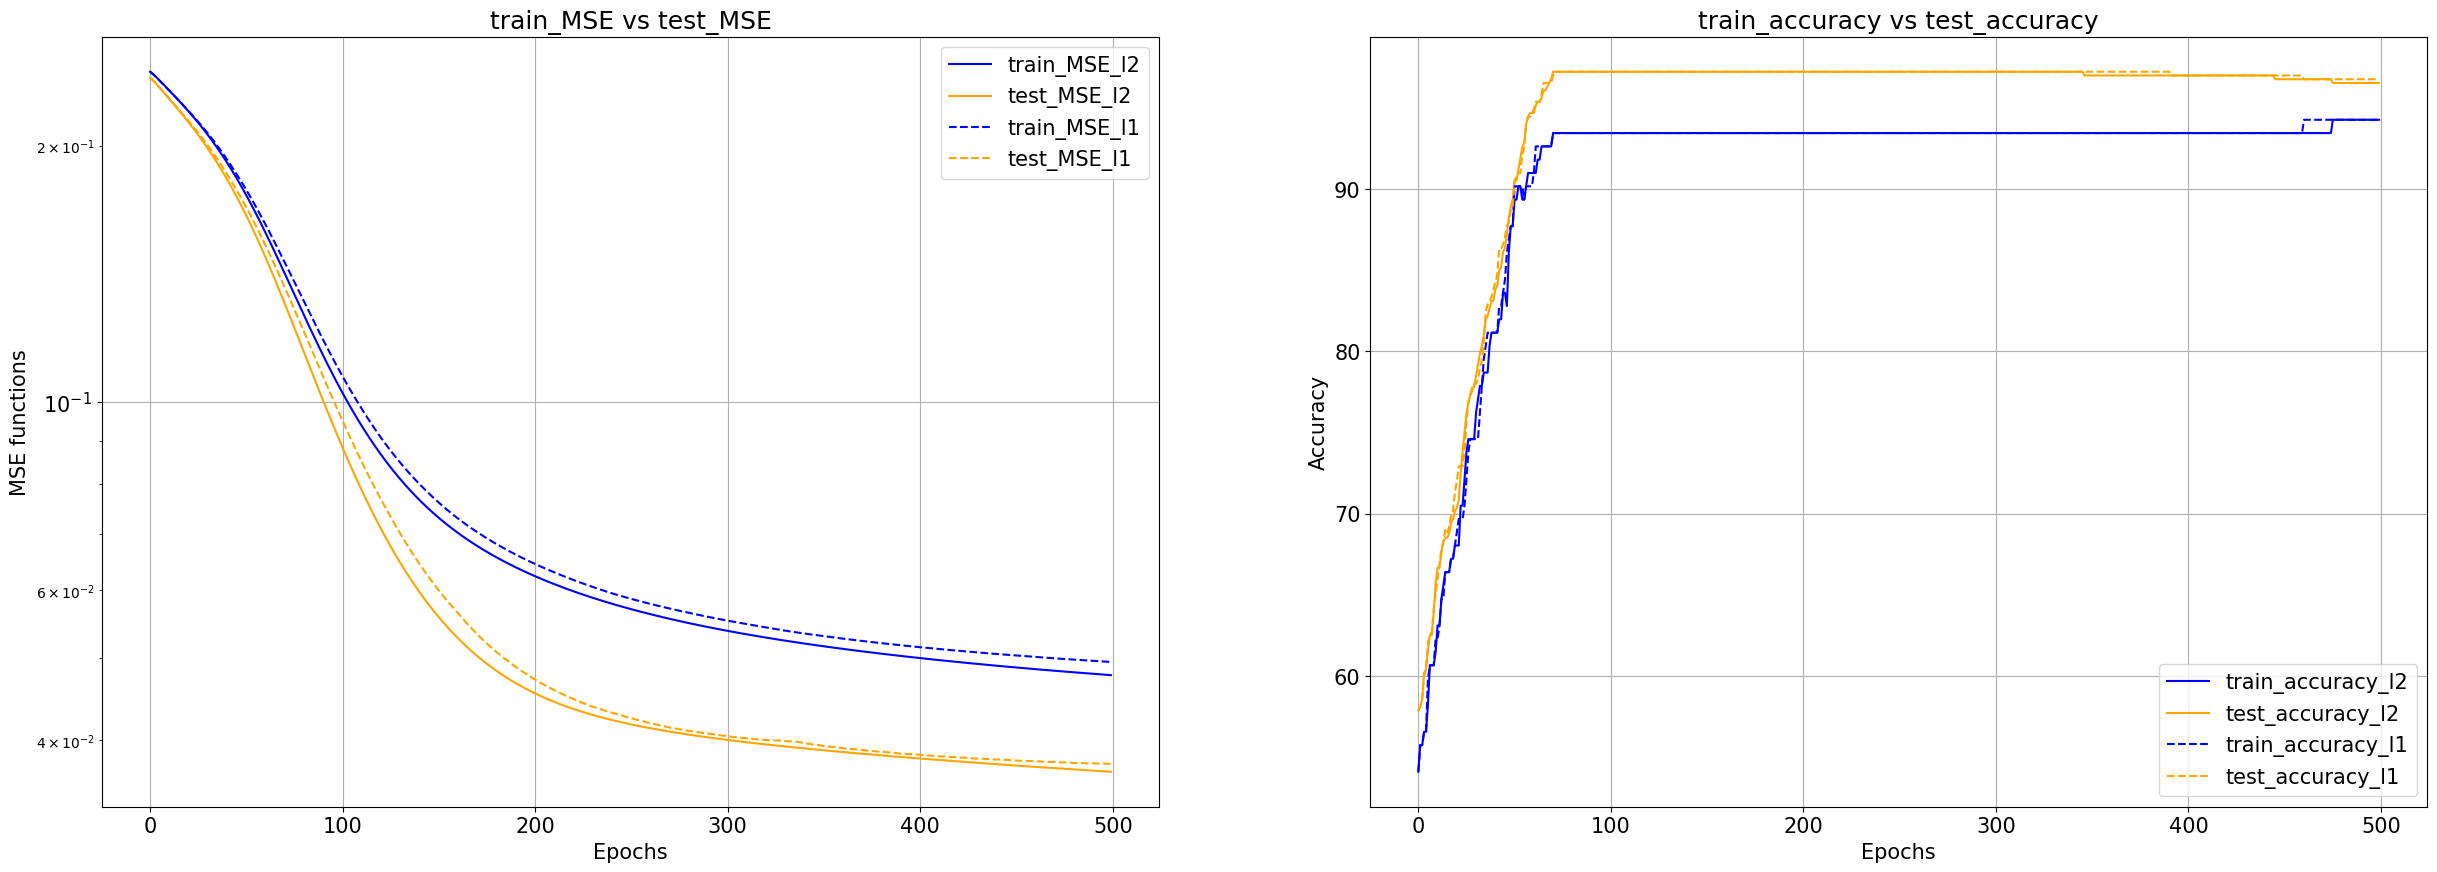

In [51]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_l2['train_MSE'], '-', label='train_MSE_l2', color='blue')
plt.plot(history_l2['test_MSE'], '-', label='test_MSE_l2', color='orange')
plt.plot(history_l1['train_MSE'], '--', label='train_MSE_l1', color='blue')
plt.plot(history_l1['test_MSE'], '--', label='test_MSE_l1', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('MSE functions', size=15)
plt.title('train_MSE vs test_MSE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_l2['train_accuracy'], '-',label='train_accuracy_l2', color='blue')
plt.plot(history_l2['test_accuracy'], '-', label='test_accuracy_l2', color='orange')
plt.plot(history_l1['train_accuracy'], '--', label='train_accuracy_l1', color='blue')
plt.plot(history_l1['test_accuracy'], '--', label='test_accuracy_l1', color='orange')
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.title('train_accuracy vs test_accuracy', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

Text(158.22222222222223, 0.5, 'Layer units')

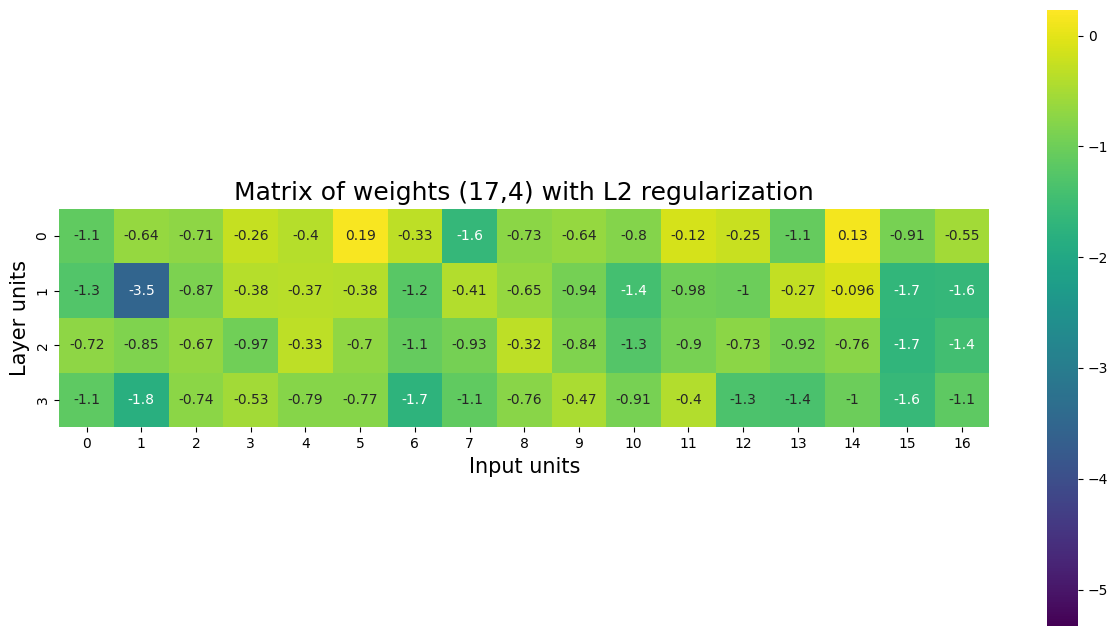

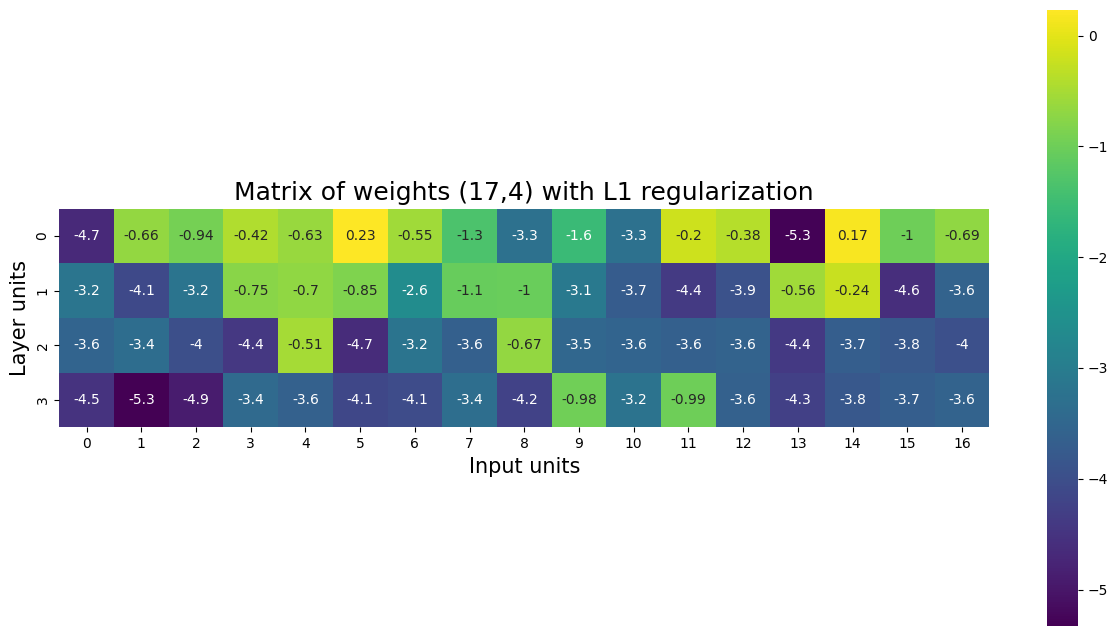

In [52]:
l2 = np.log10(np.abs(l2_weights[0][0]))
l1 = np.log10(np.abs(l1_weights[0][0]))

combined_min = min(np.min(l1), np.min(l2))
combined_max = max(np.max(l1), np.max(l2))

l2_norm = (l2 - np.min(l2)) / (np.max(l2) - np.min(l2))
l1_norm = (l1 - np.min(l1)) / (np.max(l1) - np.min(l1))

plt.figure(3,figsize=(15,8))
plt.title('Matrix of weights (17,4) with L2 regularization',size=18)
sn.heatmap(l2, annot=True,cmap='viridis',square=True,vmin=combined_min, vmax=combined_max)
plt.xlabel('Input units', size=15)
plt.ylabel('Layer units', size=15)
plt.figure(4,figsize=(15,8))
plt.title('Matrix of weights (17,4) with L1 regularization',size=18)
sn.heatmap(l1, annot=True,cmap='viridis',square=True,vmin=combined_min, vmax=combined_max)
plt.xlabel('Input units', size=15)
plt.ylabel('Layer units', size=15)

## CUP

Define training and model hyperparameters

In [80]:
orig_params = {'hidden_dim': 30,
        'hidden_act_func': 'leaky_relu',
        'hidden_dim2': 30,
        'hidden_act_func2' : 'leaky_relu',
        'hidden_dim3': 30,
        'hidden_act_func3' : 'leaky_relu',
        'eta': 0.003,
        'lam': 0.05,
        'alpha': 0.06,
        'n_batch': 150,
        'use_opt':1,
        'nest': False,
        'l1_reg' : False,
        'epochs' : 500,
        'loss' : 'MSE',
        'output_act_func': 'lin'
        }
seed = np.random.randint(seed)

### L2 regularization

Build model

In [81]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

init_weights_list = model.get_weights_list()

Training with L2 regularization:

In [82]:
np.random.seed(seed)
params['l1_reg'] = False
history_l2 = model.retrain(X_train_cup, y_train_cup,
                                    ** params,
                                    test_data=[X_test_cup, y_test_cup],
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 7.354e+02, test_loss: 6.896e+02; train_MEE: 4.191e+01, test_MEE: 3.999e+01  lr : 0.003
Epoch 1: train_loss: 6.945e+02, test_loss: 6.539e+02; train_MEE: 4.052e+01, test_MEE: 3.868e+01  lr : 0.003
Epoch 2: train_loss: 6.430e+02, test_loss: 6.098e+02; train_MEE: 3.883e+01, test_MEE: 3.715e+01  lr : 0.003
Epoch 3: train_loss: 5.796e+02, test_loss: 5.569e+02; train_MEE: 3.681e+01, test_MEE: 3.547e+01  lr : 0.003
Epoch 4: train_loss: 5.074e+02, test_loss: 4.986e+02; train_MEE: 3.470e+01, test_MEE: 3.384e+01  lr : 0.003
Epoch 5: train_loss: 4.354e+02, test_loss: 4.403e+02; train_MEE: 3.260e+01, test_MEE: 3.233e+01  lr : 0.003
Epoch 6: train_loss: 3.648e+02, test_loss: 3.818e+02; train_MEE: 3.009e+01, test_MEE: 3.039e+01  lr : 0.003
Epoch 7: train_loss: 2.969e+02, test_loss: 3.179e+02; train_MEE: 2.698e+01, test_MEE: 2.755e+01  lr : 0.003
Epoch 8: train_loss: 2.322e+02, test_loss: 2.521e+02; train_MEE: 2.347e+01, test_MEE: 2.409e+01  lr : 0.003
Epoch 9: train_loss: 1.747e+

In [83]:
l2_weights = model.get_weights_list()

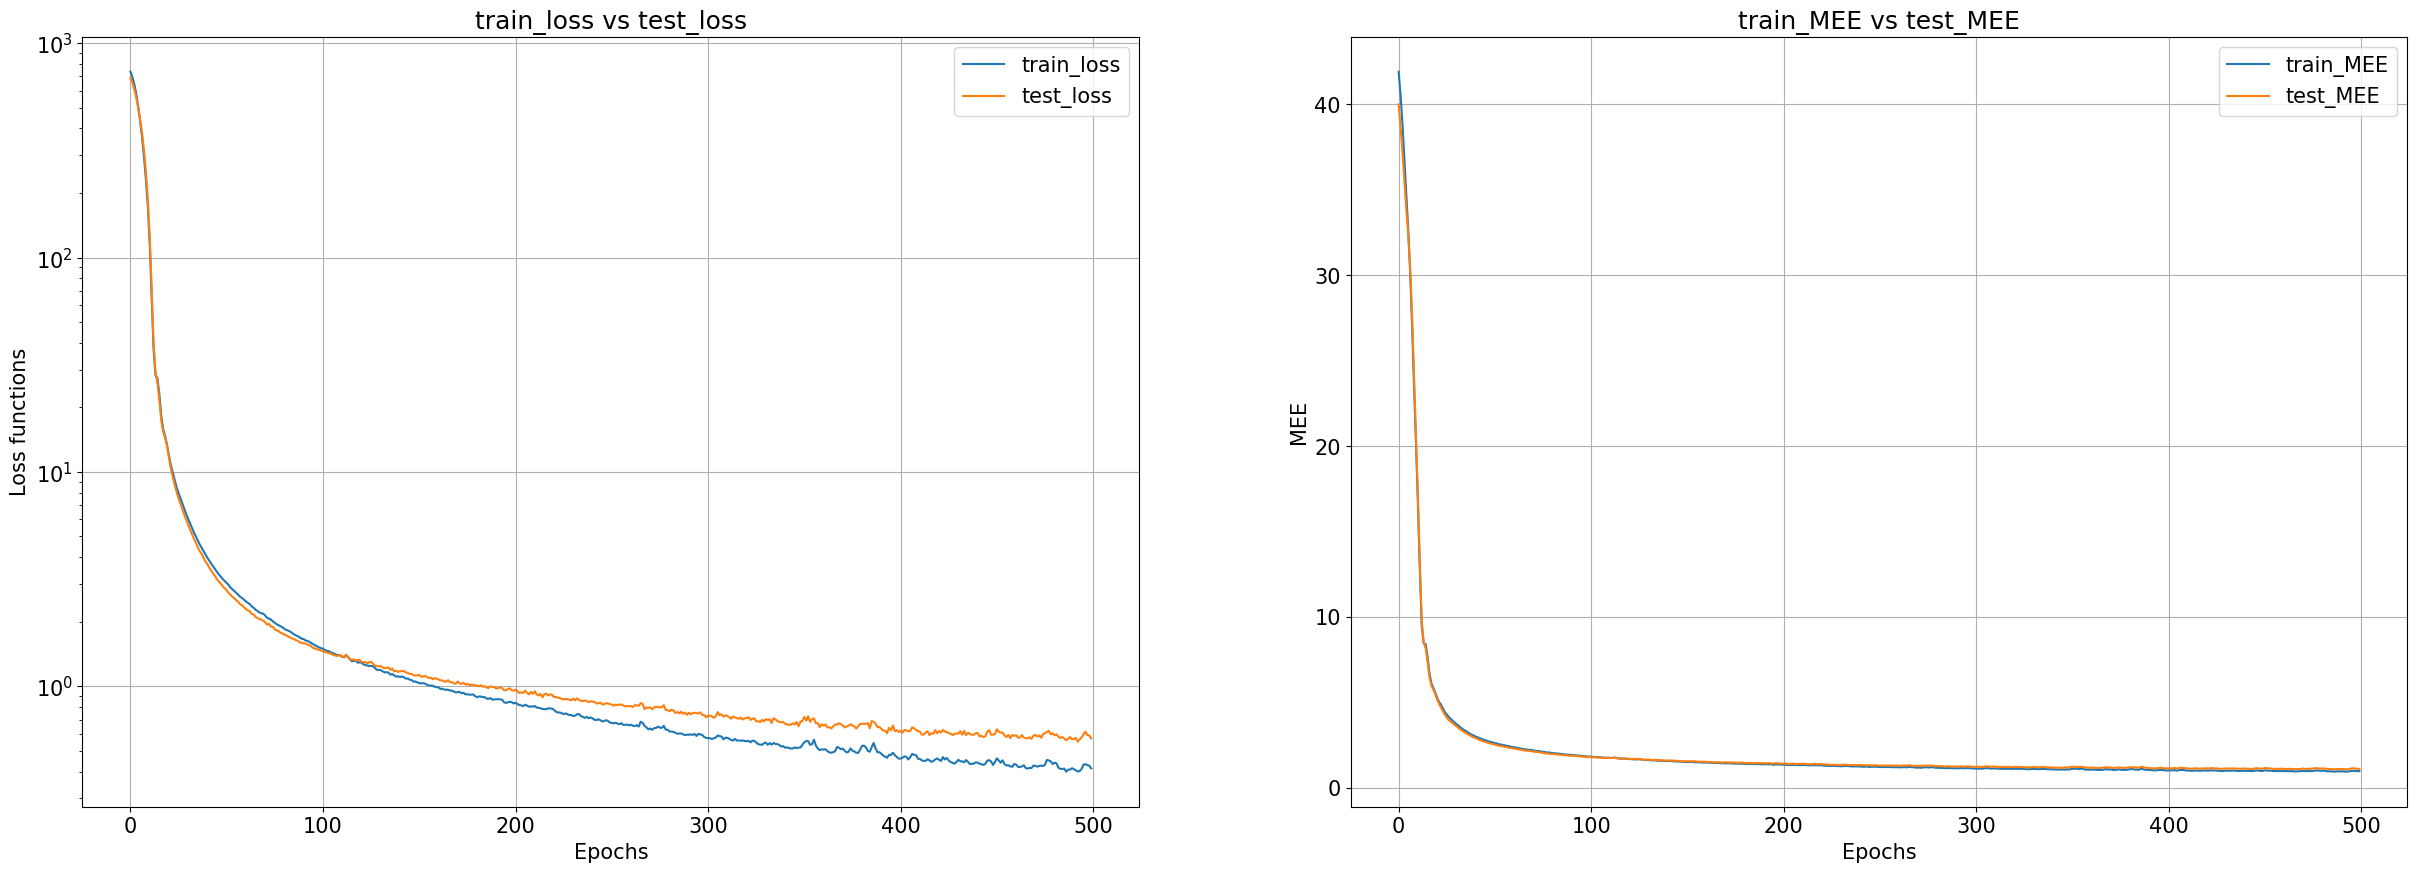

In [84]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_l2['train_loss'],label='train_loss')
plt.plot(history_l2['test_loss'], label='test_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs test_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_l2['train_MEE'],label='train_MEE')
plt.plot(history_l2['test_MEE'], label='test_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs test_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

### L1 regularization


Build model


In [85]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

model.set_initial_weights(init_weights_list)

Training with L1 regularization:


In [86]:
np.random.seed(seed)
params['l1_reg'] = True
history_l1 = model.retrain(X_train_cup, y_train_cup,
                                    ** params,
                                    test_data=[X_test_cup, y_test_cup],
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 7.354e+02, test_loss: 6.896e+02; train_MEE: 4.191e+01, test_MEE: 3.999e+01  lr : 0.003
Epoch 1: train_loss: 6.945e+02, test_loss: 6.539e+02; train_MEE: 4.052e+01, test_MEE: 3.868e+01  lr : 0.003
Epoch 2: train_loss: 6.430e+02, test_loss: 6.098e+02; train_MEE: 3.883e+01, test_MEE: 3.715e+01  lr : 0.003
Epoch 3: train_loss: 5.796e+02, test_loss: 5.569e+02; train_MEE: 3.681e+01, test_MEE: 3.547e+01  lr : 0.003
Epoch 4: train_loss: 5.074e+02, test_loss: 4.986e+02; train_MEE: 3.470e+01, test_MEE: 3.384e+01  lr : 0.003
Epoch 5: train_loss: 4.354e+02, test_loss: 4.403e+02; train_MEE: 3.260e+01, test_MEE: 3.233e+01  lr : 0.003
Epoch 6: train_loss: 3.648e+02, test_loss: 3.818e+02; train_MEE: 3.009e+01, test_MEE: 3.039e+01  lr : 0.003
Epoch 7: train_loss: 2.969e+02, test_loss: 3.179e+02; train_MEE: 2.698e+01, test_MEE: 2.755e+01  lr : 0.003
Epoch 8: train_loss: 2.322e+02, test_loss: 2.521e+02; train_MEE: 2.347e+01, test_MEE: 2.409e+01  lr : 0.003
Epoch 9: train_loss: 1.747e+

In [87]:
l1_weights = model.get_weights_list()

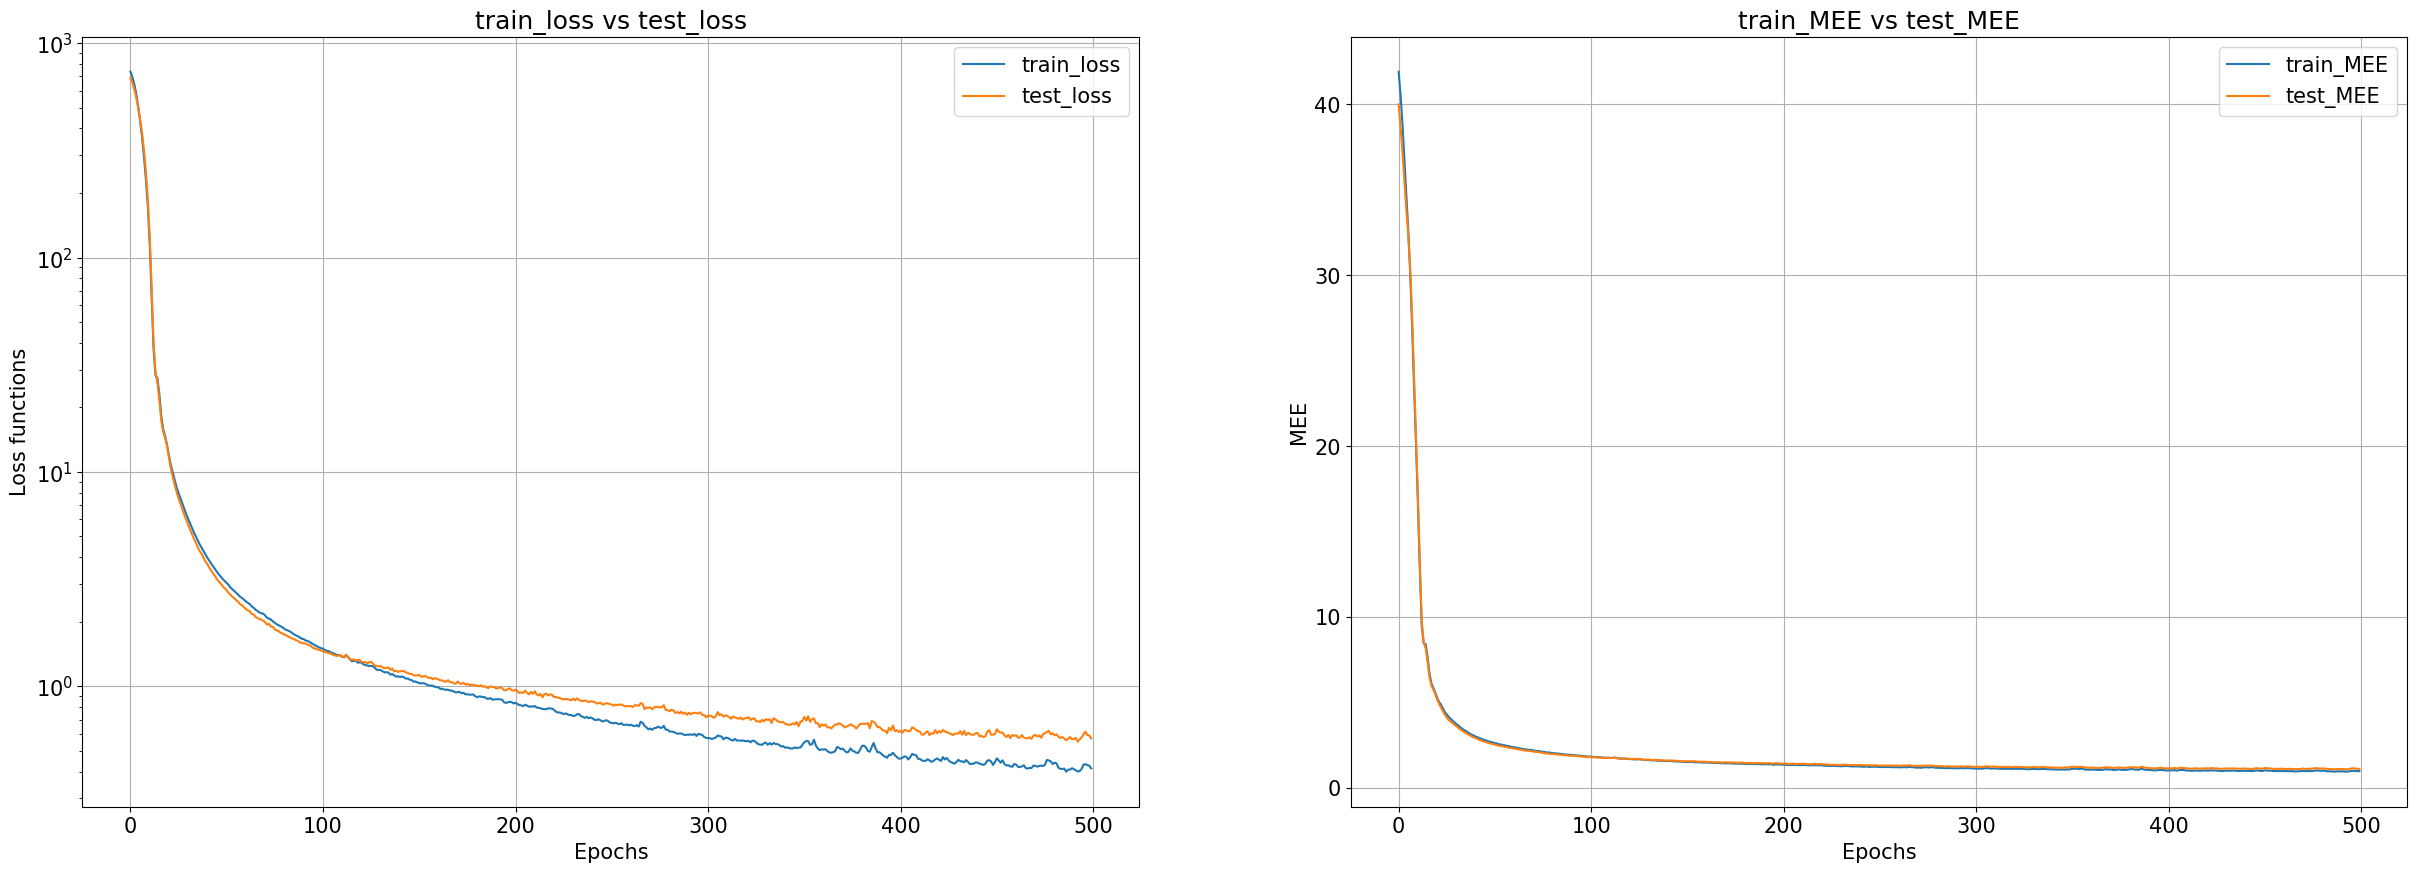

In [88]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_l1['train_loss'],label='train_loss')
plt.plot(history_l1['test_loss'], label='test_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs test_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_l1['train_MEE'],label='train_MEE')
plt.plot(history_l1['test_MEE'], label='test_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs test_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)


### Comparison

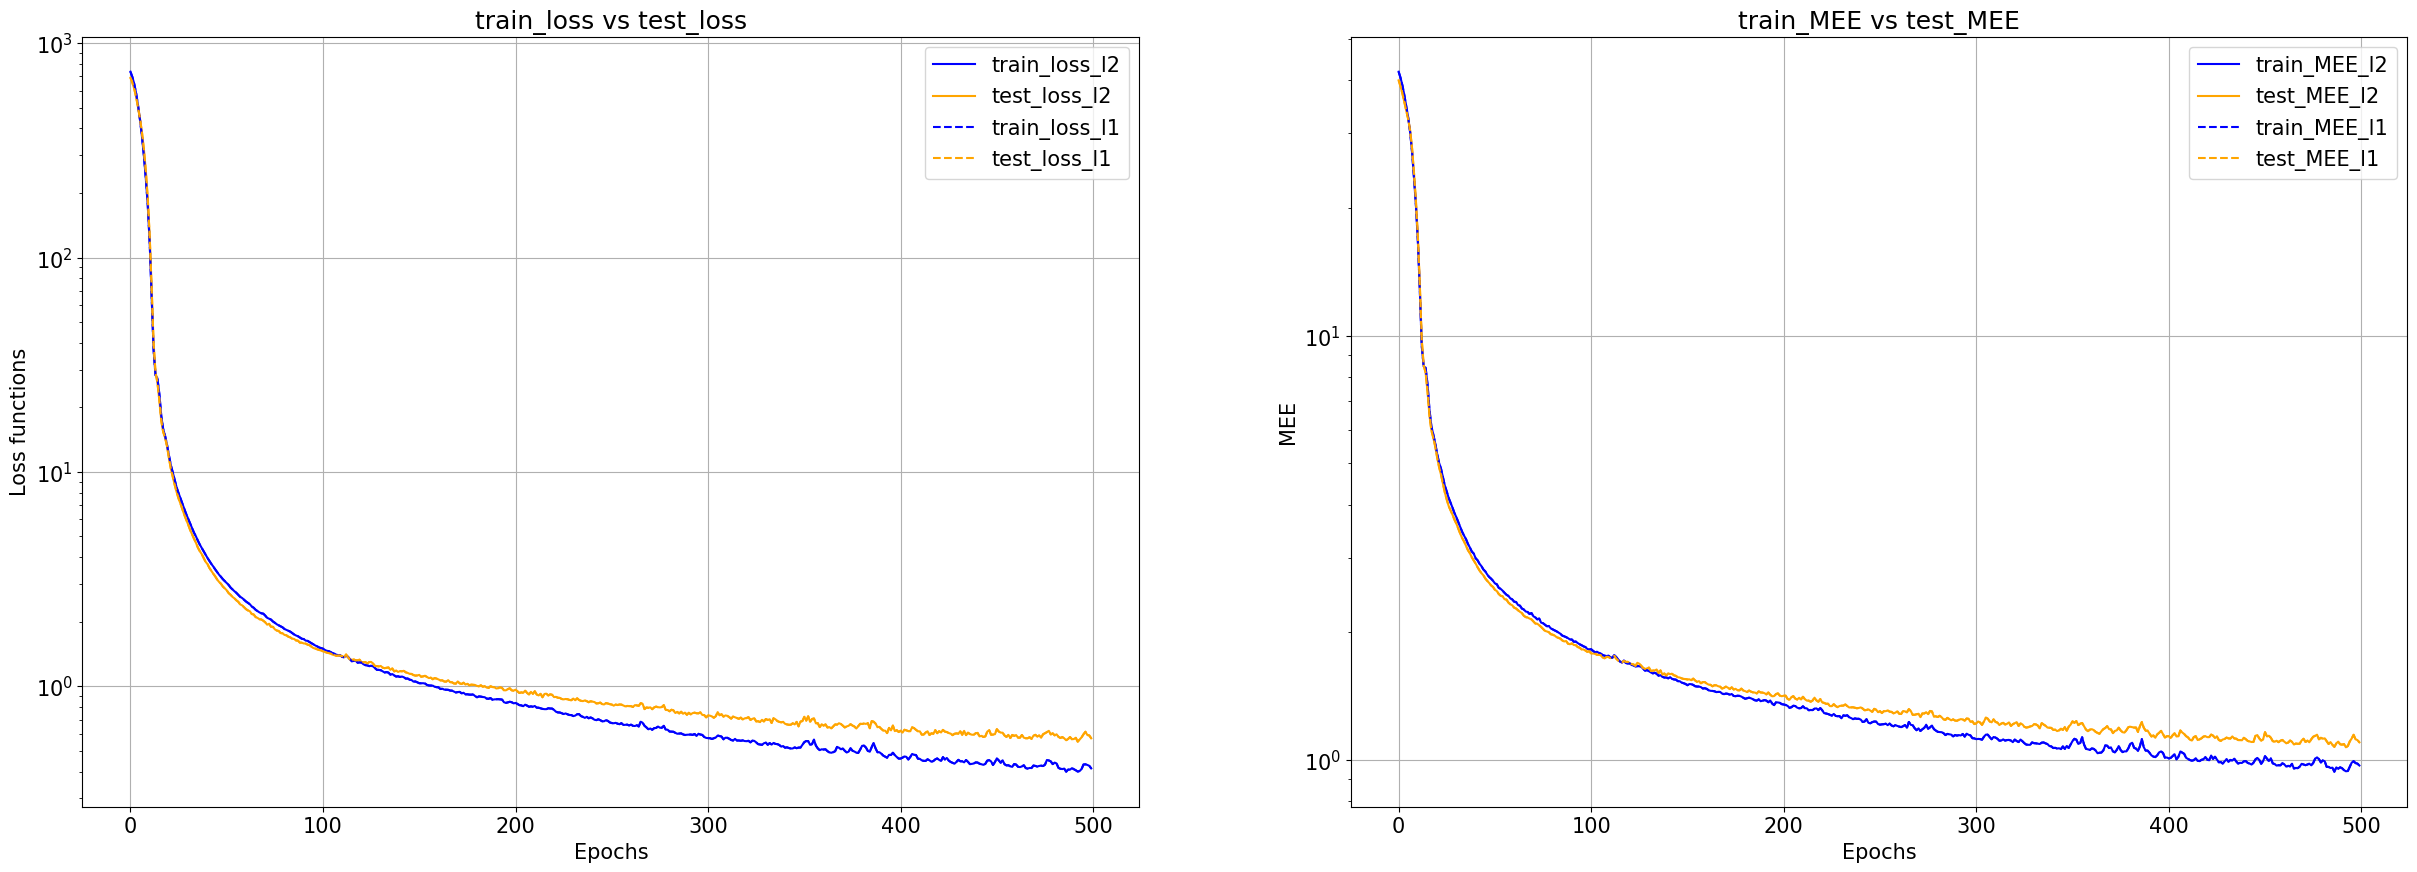

In [89]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_l2['train_loss'], '-', label='train_loss_l2', color='blue')
plt.plot(history_l2['test_loss'], '-', label='test_loss_l2', color='orange')
plt.plot(history_l1['train_loss'], '--', label='train_loss_l1', color='blue')
plt.plot(history_l1['test_loss'], '--', label='test_loss_l1', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs test_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_l2['train_MEE'], '-',label='train_MEE_l2', color='blue')
plt.plot(history_l2['test_MEE'], '-', label='test_MEE_l2', color='orange')
plt.plot(history_l1['train_MEE'], '--', label='train_MEE_l1', color='blue')
plt.plot(history_l1['test_MEE'], '--', label='test_MEE_l1', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs test_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

Text(472.2222222222223, 0.5, 'Layer units')

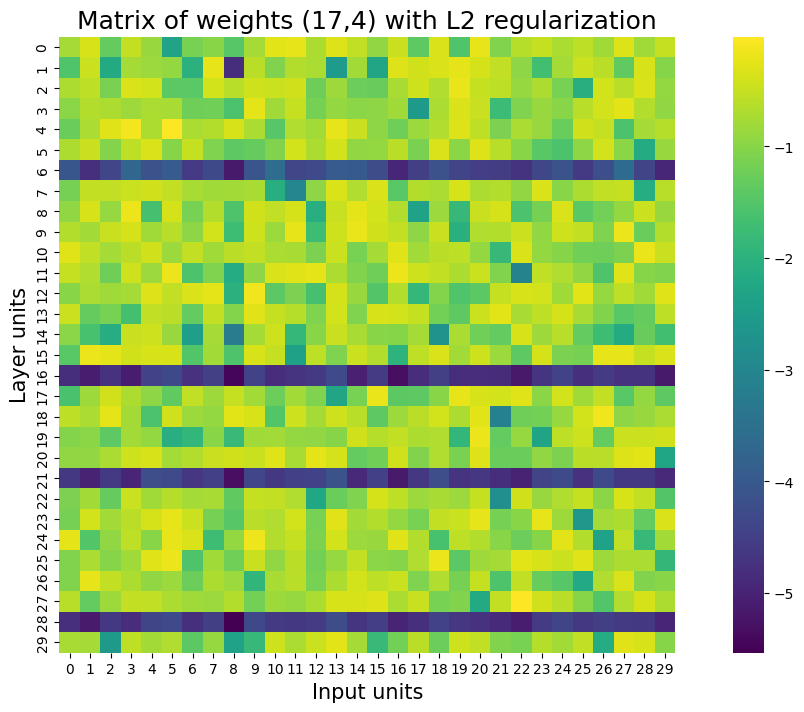

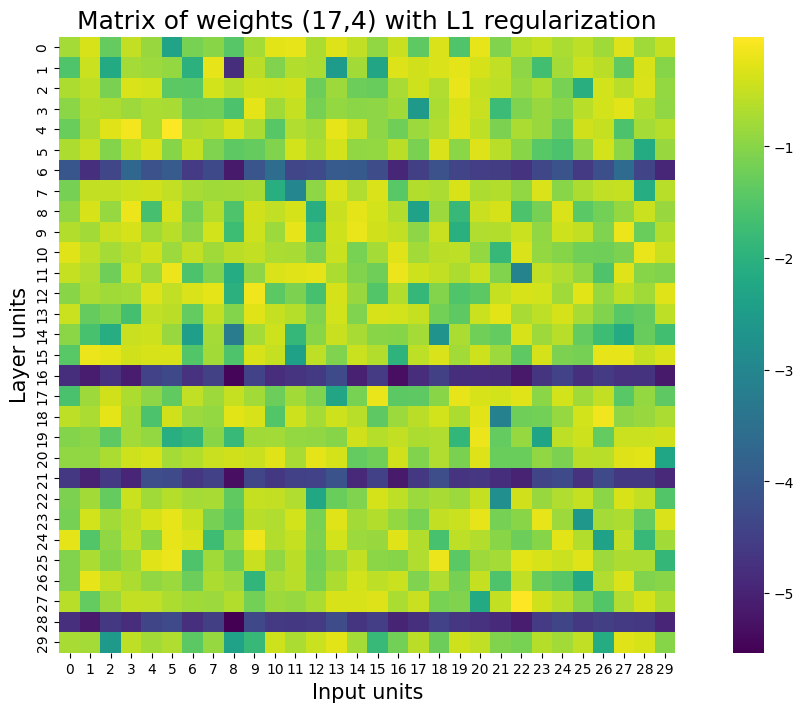

In [90]:
l2 = np.log10(np.abs(l2_weights[1][0]))
l1 = np.log10(np.abs(l1_weights[1][0]))

combined_min = min(np.min(l1), np.min(l2))
combined_max = max(np.max(l1), np.max(l2))

l2_norm = (l2 - np.min(l2)) / (np.max(l2) - np.min(l2))
l1_norm = (l1 - np.min(l1)) / (np.max(l1) - np.min(l1))

plt.figure(3,figsize=(15,8))
plt.title('Matrix of weights (17,4) with L2 regularization',size=18)
sn.heatmap(l2, annot=False,cmap='viridis',square=True,vmin=combined_min, vmax=combined_max)
plt.xlabel('Input units', size=15)
plt.ylabel('Layer units', size=15)
plt.figure(4,figsize=(15,8))
plt.title('Matrix of weights (17,4) with L1 regularization',size=18)
sn.heatmap(l1, annot=False,cmap='viridis',square=True,vmin=combined_min, vmax=combined_max)
plt.xlabel('Input units', size=15)
plt.ylabel('Layer units', size=15)